In [36]:
# ! pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"

In [59]:
test = {'a':1.0, 'b':2, 'c': 'c'}

sum([int(i) for i in list(test.values()) if type(i) == int or type(i) == float])

3

# Import data

In [3]:
df_comp = pd.read_excel('../data/family_composition_2016_amsterdam.xlsx', skiprows=2)
df_price = pd.read_excel('../data/woz_prices_2015_amsterdam.xlsx', skiprows=2)

## Exploratory data analysis
Explore the housing prices and family compositions per area. Any outliers, insights or
other things of note?

In [4]:
## Check NaNs & drop them
df_comp = df_comp.dropna()
df_price = df_price.dropna()

# Merge dfs
df_all = df_comp.merge(df_price, how='outer', left_on='area', right_on='area')

# Remove row with index = 481, as it seems to be the total
total = df_all.iloc[481]
df_all = df_all.drop(481, axis=0)
df_all = df_all.drop('woz-value per m2', axis=1)

In [5]:
features = [
    'single', 'married, no kids',
    'not married, no kids', 'married, with kids',
    'not married, with kids', 'single parent',
    'other', 'total'
]

target = 'average woz value'

# some features contain a '-', let's replace it with 0 so we can change it to a float.
for feature in features:
    df_all.loc[df_all[feature] == '-', feature] = 0
    df_all[feature] = df_all[feature].astype(float)
    
# the target contains '.' values, let replace it with np.nan so we can change it to a float
df_all.loc[df_all[target] == '.', target] = np.nan
df_all[target] = df_all[target].astype(float)
    
df_all[features].describe()

single  married, no kids  not married, no kids  \
count   481.000000        481.000000            481.000000   
mean    497.253638         85.062370            106.172557   
std     441.337841         79.029717            105.276152   
min       0.000000          0.000000              0.000000   
25%      96.000000         13.000000             20.000000   
50%     441.000000         69.000000             82.000000   
75%     758.000000        127.000000            156.000000   
max    2130.000000        366.000000            617.000000   

       married, with kids  not married, with kids  single parent       other  \
count          481.000000              481.000000     481.000000  481.000000   
mean           106.844075               44.367983      82.993763   12.956341   
std            120.581070               42.696552      88.839919   13.701588   
min              0.000000                0.000000       0.000000    0.000000   
25%             11.000000                6.000000       6.000000    2.000000   
50%             73.000000               37.000000      62.000000    9.000000   
75%            156.000000               70.000000     130.000000   20.000000   
max            812.000000              295.000000     612.000000   89.000000   

             total  
count   481.000000  
mean    935.650728  
std     781.214132  
min       0.000000  
25%     207.000000  
50%     838.000000  
75%    1488.000000  
max    3419.000000

I will plot a histogram of each numerical feature to check the distribution. I notice a few things:
* All distributions are right skewed (have a tail to the right).
* All features have the '0-49' as their largest bin.
* The features 'single', 'not married, no kids', 'married, with kids', 'single parent', & 'total' have one area with a relative high value compared to the rest of the distribution. 

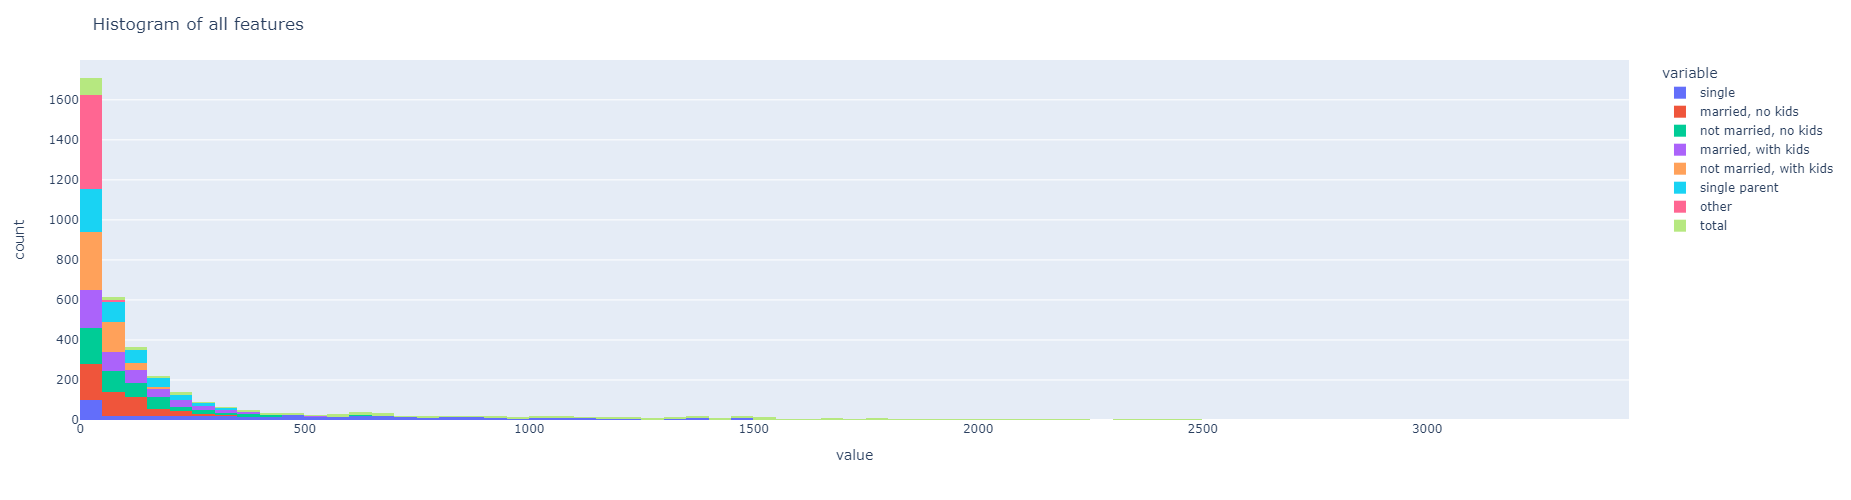

In [6]:
fig = df_all[features].hist()
fig.update_layout(title='Histogram of all features',
                 height=500, width=1500)
fig.show()

I'll quickly check which areas have the highest number of a certain family-composition by sorting the data. <br>
* It looks like the 'K24e Sarphatiparkbuurt' has the highest number of single people. As this is located in the Pijp, this does indeed make sense.
* Sorting by 'married, with kids', we see that 'De Aker Oost' is the most popular area. As there is a bit more space there, this also makes sense.

In [7]:
feature = 'married, with kids'
df_all.sort_values(by=feature, ascending=False)

area  single  married, no kids  \
183                  F84c De Aker Oost   601.0             352.0   
187         F86a Overtoomse Veld Noord   909.0             209.0   
178  F82d Zuidwestkwadrant Osdorp Zuid  1131.0             267.0   
163                       F78d Buurt 9   933.0             285.0   
182                  F84b De Aker West   581.0             295.0   
..                                 ...     ...               ...   
413        N71e Cornelis Douwesterrein    16.0               0.0   
167                       F80a Ookmeer     3.0               0.0   
180       F83b Bedrijvencentrum Osdorp     6.0               0.0   
192  F86f Lucas/Andreasziekenhuis e.o.   646.0               1.0   
418           N72b Zamenhofstraat e.o.     4.0               0.0   

     not married, no kids  married, with kids  not married, with kids  \
183                 128.0               812.0                   170.0   
187                 286.0               648.0                    94.0   
178                 276.0               643.0                   152.0   
163                 183.0               624.0                   104.0   
182                 123.0               560.0                   126.0   
..                    ...                 ...                     ...   
413                   0.0                 0.0                     1.0   
167                   1.0                 0.0                     0.0   
180                   0.0                 0.0                     0.0   
192                   2.0                 0.0                     0.0   
418                   0.0                 0.0                     0.0   

     single parent  other   total  average woz value  
183          238.0   14.0  2315.0           299891.0  
187          268.0   37.0  2451.0           181281.0  
178          268.0   37.0  2774.0           206445.0  
163          258.0   31.0  2418.0           172239.0  
182          203.0   15.0  1903.0           258974.0  
..             ...    ...     ...                ...  
413            1.0    0.0    18.0                NaN  
167            0.0    0.0     4.0                NaN  
180            0.0    0.0     6.0                NaN  
192            0.0    0.0   649.0                NaN  
418            0.0    0.0     4.0                NaN  

[481 rows x 10 columns]

Now I'll take a look at the average value. First I'll check the mean, min and max with the .describe() method. <br>
An average mean price of ca. 260 000 really seems like a dream nowadays...

In [8]:
df_all[[target]].describe()

average woz value
count       3.820000e+02
mean        2.612006e+05
std         1.337475e+05
min         4.628700e+04
25%         1.771055e+05
50%         2.300575e+05
75%         2.965090e+05
max         1.295077e+06

Looking at the distribution of avg. woz price we again see it is right skewed. The following points should be noted:
* Most areas have a price that falls in the '150k - 199k' bin.
* There is one outlier area with a price in the range: '1.25M - 1.99M'
* There is one area with a price in the range: '0 - 49k'

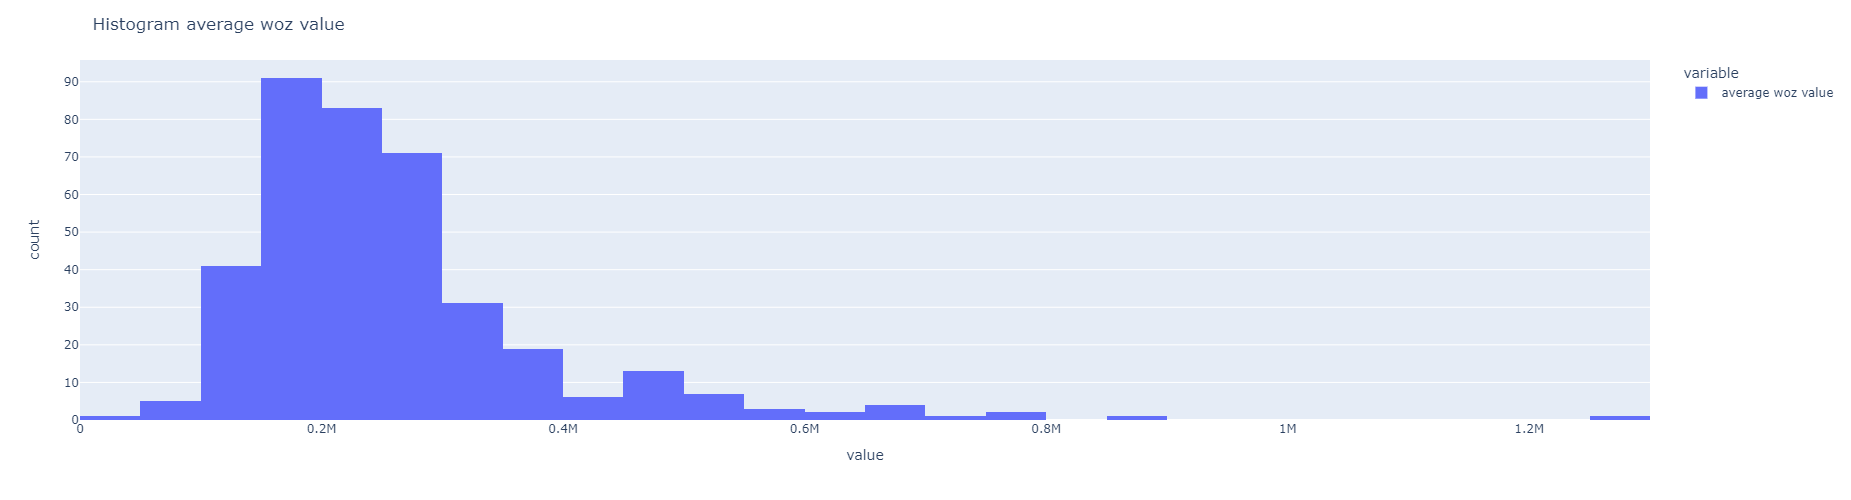

In [9]:
fig = df_all[target].hist()
fig.update_layout(title=f'Histogram {target}',
                 height=500, width=1500)
fig.show()

I'll quickly check the highest price and lowest prices areas by sorting the data. 
* The Diepenrockbuurt is the most expensive, which definetly makes sense. 
* The NDSM terrein is the least expensive, which also makes sense (although 46287 does seem a bit low..?)

In [10]:
df_all.sort_values(by=target, ascending=False).dropna()

area  single  married, no kids  \
258          K49a Diepenbrockbuurt   121.0              57.0   
246             K47e Banpleinbuurt   150.0              76.0   
259            K49b Beethovenbuurt   247.0              93.0   
240    K46c Willemsparkbuurt Noord   365.0              90.0   
245      K47d Cornelis Schuytbuurt   664.0             200.0   
..                             ...     ...               ...   
360          M58b Weespertrekvaart   934.0               4.0   
320  M34c Zeeburgereiland Zuidoost   294.0               2.0   
78            E12a Houthavens West   201.0              13.0   
442                   T93c D-buurt  1462.0              13.0   
414              N71f NDSM terrein   368.0               0.0   

     not married, no kids  married, with kids  not married, with kids  \
258                  19.0                92.0                    18.0   
246                  29.0                74.0                    20.0   
259                  44.0               136.0                    25.0   
240                 100.0               136.0                    45.0   
245                 139.0               266.0                    91.0   
..                    ...                 ...                     ...   
360                  63.0                 1.0                     1.0   
320                  35.0                 2.0                     1.0   
78                   36.0                16.0                     6.0   
442                  98.0                11.0                    16.0   
414                  14.0                 0.0                     0.0   

     single parent  other   total  average woz value  
258           17.0    7.0   331.0          1295077.0  
246           25.0    2.0   376.0           887619.0  
259           33.0    7.0   585.0           782514.0  
240           42.0   10.0   788.0           762260.0  
245           69.0   22.0  1451.0           729032.0  
..             ...    ...     ...                ...  
360            2.0    4.0  1009.0            75644.0  
320            8.0    3.0   345.0            74185.0  
78             4.0    1.0   277.0            66139.0  
442           76.0    8.0  1684.0            54813.0  
414            4.0    1.0   387.0            46287.0  

[382 rows x 10 columns]

#### Make an extra feature out of the area
From the quick analysis above (and common knowledge), it is clear that the average price of a house is dependent on the area it is in. <br>
Therefore the area column will be used to create an extra categorical 'area-code' feature by taking the letter-digit code e.g. 'A00'. <br> 
Below we plot the average price per area-code and immediately see there are some areas that have higher of lower prices.

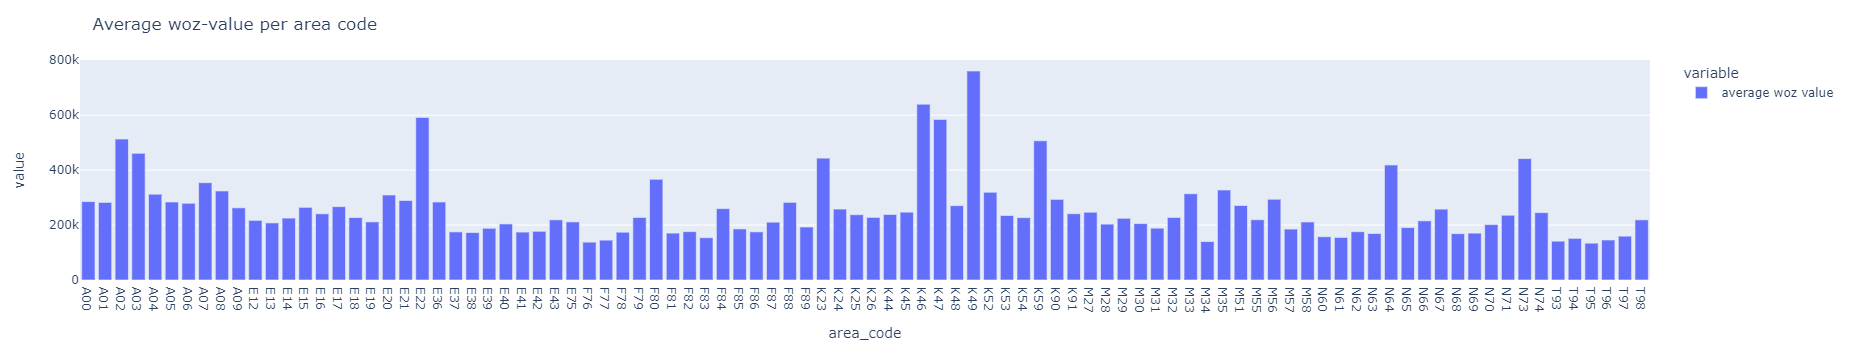

In [11]:
df_all['area_code'] = df_all['area'].str[:3]
# add the 'area_code' to the list of features
feature_area = features + ['area_code']

# Plot the average price per area code
fig = df_all[['area_code', target]].dropna().groupby('area_code').mean().plot.bar()
fig.update_layout(title='Average woz-value per area code')
fig.show()

## Relation between woz and family composition
Assess the relation between average WOZ value and family composition for each
family composition separately.<br>
The following can be noted by plotting the family-composition vs the average WOz value:
* All features have a negative correlation with the price. This really just means: the more people live in an area --> the lower the average price. 
* We see that no feature has a very strong linear relationship with the price. 
* Intuitively we would expect: more single parents --> lower house price. This relationship is somewhat visible from the plot.
* Intuitively we would expect: more singles --> lower house price. This relationship is somewhat visible from the plot.
* We see that in the lower population regions, there can be quite some variation in the price. 

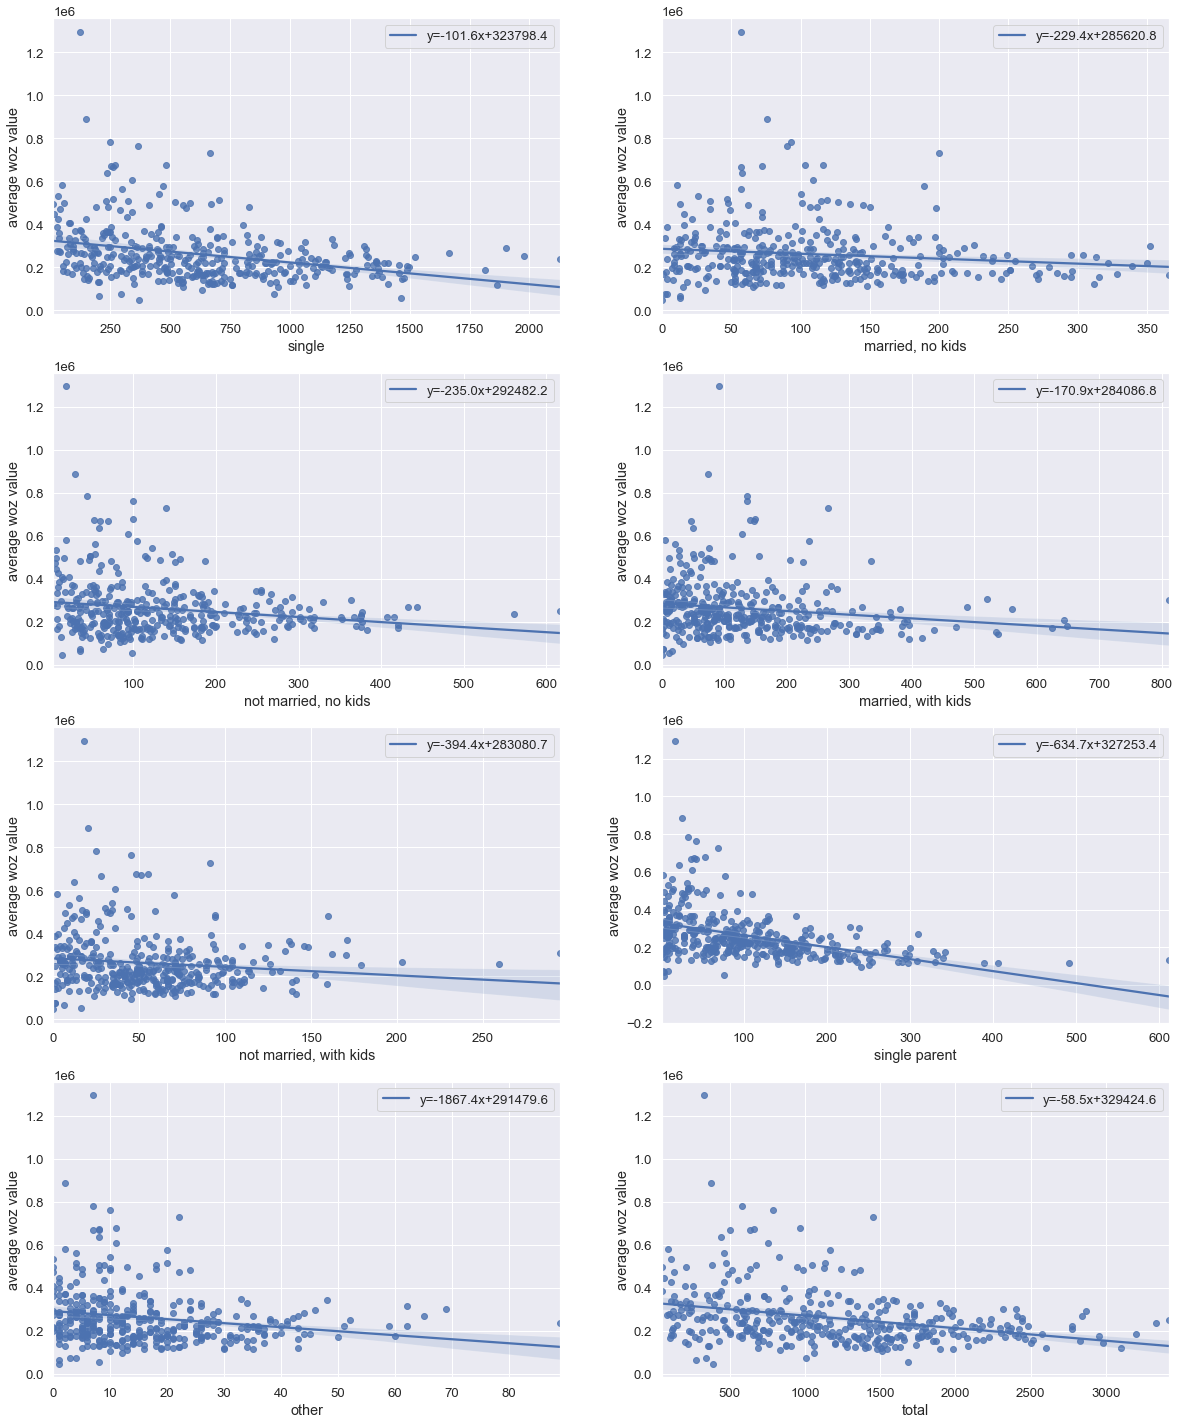

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_style("whitegrid")
sns.set(font_scale = 1.2)

df_no_na = df_all.dropna()
fig, axes = plt.subplots(4, 2)
for i, feature in enumerate(features):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_no_na[feature].values, df_no_na[target].values)
    ax = sns.regplot(data=df_no_na, x=feature, y=target, ax=axes[i//2, i%2], 
               line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})#.set_title(feature)
    ax.legend()
plt.gcf().set_size_inches(20, 25)

## Linear Regression
#### Fit a linear model that predicts the average WOZ value of an area based on the family compositions and analyze the performance of this model. Make sure to report at least the R-Squared score. <br>
I start off with a very simple LR model using all of our features. I shuffle the data, and in order to calculate an error metric, the data is split into a train and test set. <br>
Note: care has been taken to fit the encoder on the train set (NOT the train and test set together). 

In [13]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

test_ratio = 0.2
train_test = df_all.dropna()

X_train, X_test, y_train, y_test = train_test_split(train_test[feature_area], train_test[target], test_size=test_ratio, random_state=123)

ohc = OneHotEncoder(handle_unknown='ignore')

ohe = ohc.fit_transform(X_train.area_code.values.reshape(-1,1)).toarray() 
df_one_hot = pd.DataFrame(ohe, columns = ohc.categories_[0])
X_train = pd.concat([X_train.reset_index(drop=True), df_one_hot], axis=1)
X_train = X_train.drop('area_code', axis=1)

ohe = ohc.transform(X_test.area_code.values.reshape(-1,1)).toarray() 
df_one_hot = pd.DataFrame(ohe, columns = ohc.categories_[0])
X_test = pd.concat([X_test.reset_index(drop=True), df_one_hot], axis=1)
X_test = X_test.drop('area_code', axis=1)

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

LinearRegression()

### Compute a base-line prediction, based on the mean value of the test-set
Just to make sure that our LR model performs better than the most simple prediction, the RMSE is calculated for when the mean price of the train set is predicted for each area. 

In [14]:
# Base line: take mean of the train set
mean = y_train.mean()
print("Base line root mean squared error: %.2f" % mean_squared_error(y_test, [mean]*len(y_test))**0.5)

Base line root mean squared error: 116635.89


We see that our LR model does indeed perform much better than the base-line. 

In [15]:
y_pred = regr.predict(X_test)

# print("Coefficients: \n", regr.coef_)
rmse =  mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)
y_train_pred = regr.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

print("LR root mean squared error: %.2f" % rmse)
print("Test coefficient of determination: %.2f" % r2)
print("Train coefficient of determination: %.2f" % r2_train)

LR root mean squared error: 82904.43
Test coefficient of determination: 0.49
Train coefficient of determination: 0.82


By plotting the true-values vs the predicted values, we would hope to see a straight line...

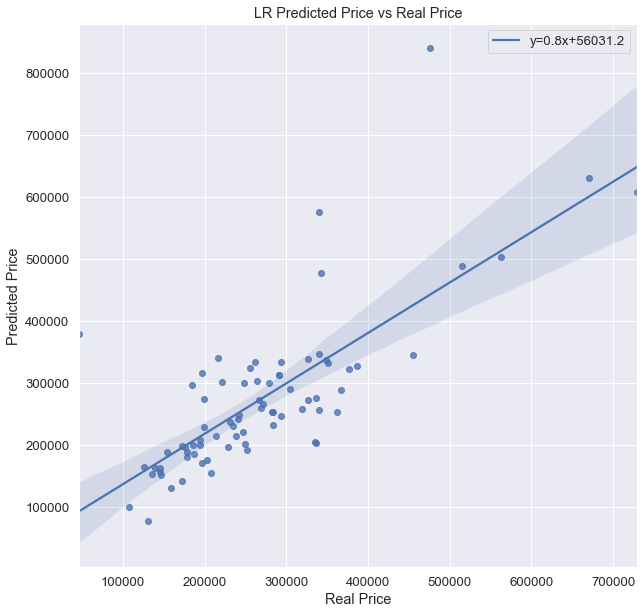

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test.values, y_pred)
fig = plt.plot()
ax = sns.regplot( x=y_test.values, y=y_pred, 
           line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})#.set_title(feature)
ax.legend()
ax.set_title('LR Predicted Price vs Real Price')
ax.set_xlabel("Real Price")
ax.set_ylabel("Predicted Price")
plt.gcf().set_size_inches(10, 10)

#### Quickly check performance without the 'area_code' feature
Just to make sure that the 'area_code' feature that was added helps the model, a LR model was fitted only on the family-composition features. <br>
From the much lower R2 score, and higher RMSE score it is clear that the 'area_code' feature increases performance. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_test[features], train_test[target], test_size=test_ratio, random_state=123)

regr_2 = linear_model.LinearRegression()

regr_2.fit(X_train, y_train)

y_pred = regr_2.predict(X_test)
y_train_pred = regr_2.predict(X_train)
r2_train_2 = r2_score(y_train, y_train_pred)

rmse_no_area =  mean_squared_error(y_test, y_pred)**0.5
r2_no_area = r2_score(y_test, y_pred)
print("LR root mean squared error: %.2f" % rmse_no_area)
print("Test coefficient of determination: %.2f" % r2_no_area)
print("Train coefficient of determination: %.2f" % r2_train_2)

LR root mean squared error: 98161.49
Test coefficient of determination: 0.29
Train coefficient of determination: 0.24


## Compute cross-validation metrics
To make sure I am not overfitting on the train split, I'll run a k-fold cross validation. <br>
I'll also try out some different regression models just to be sure which is the best.

In [18]:
def get_metrics(model, X_train, X_test, y_train, y_test):
    """Simple function to compute rmse & r2"""
    ohc = OneHotEncoder(handle_unknown='ignore')
    ohe = ohc.fit_transform(X_train.area_code.values.reshape(-1,1)).toarray() 
    df_one_hot = pd.DataFrame(ohe, columns = ohc.categories_[0])
    X_train = pd.concat([X_train.reset_index(drop=True), df_one_hot], axis=1)
    X_train = X_train.drop('area_code', axis=1)
    ohe = ohc.transform(X_test.area_code.values.reshape(-1,1)).toarray() 
    df_one_hot = pd.DataFrame(ohe, columns = ohc.categories_[0])
    X_test = pd.concat([X_test.reset_index(drop=True), df_one_hot], axis=1)
    X_test = X_test.drop('area_code', axis=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse =  mean_squared_error(y_test, y_pred)**0.5
    r2_test= r2_score(y_test, y_pred)
    
    y_train_pred = model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    return rmse, r2_test, r2_train

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

lr = linear_model.LinearRegression()
rf = RandomForestRegressor()
xgb = XGBRegressor()
svr = SVR()

models = [lr, rf, xgb, svr]

In [20]:
from sklearn.model_selection import KFold

for model in models:
    kfold = KFold(10, shuffle=True, random_state=1)
    train_test = df_all.dropna()

    rmses = []
    r2s_test = []
    r2s_train = []

    for train, test in kfold.split(train_test):
        X_train = train_test[feature_area].iloc[train]
        y_train = train_test[target].iloc[train]
        X_test = train_test[feature_area].iloc[test]
        y_test = train_test[target].iloc[test]

        rmse, r2_test, r2_train = get_metrics(model, X_train, X_test, y_train, y_test)

        rmses.append(rmse)
        r2s_test.append(r2_test)
        r2s_train.append(r2_train)

    print(f"For model = {str(model).split('(')[0]}")
    print()
    print(f"Mean RMSE for 10-fold CV = {round(np.array(rmses).mean())}")
    print(f"Mean test r2 for 10-fold CV = {round(np.array(r2s_test).mean(),4)}")
    print(f"Mean train r2 for 10-fold CV = {round(np.array(r2s_train).mean(),4)}")
    print()


For model = LinearRegression

Mean RMSE for 10-fold CV = 79087
Mean test r2 for 10-fold CV = 0.594
Mean train r2 for 10-fold CV = 0.8001

For model = RandomForestRegressor

Mean RMSE for 10-fold CV = 84427
Mean test r2 for 10-fold CV = 0.5579
Mean train r2 for 10-fold CV = 0.938

For model = XGBRegressor

Mean RMSE for 10-fold CV = 81495
Mean test r2 for 10-fold CV = 0.5905
Mean train r2 for 10-fold CV = 0.9989

For model = SVR

Mean RMSE for 10-fold CV = 132909
Mean test r2 for 10-fold CV = -0.0589
Mean train r2 for 10-fold CV = -0.0524



By looking at the results of the CV, we can feel confident in that our train-test split did not result in overfitting on the train set. <br>
We also see that the LR model has the best performance. 

## Prediction of areas: 'E41d', 'E15b', 'A09a'

In [21]:
def encode_area(ohc, df):
    """ Encodes the area_code column of the data-frame with
    pre-fitted OneHotEncoder. 
    Args:
        ohc (OneHotEncoder): As fitted on the train-set.
        df (pd.DataFrame): Datatframe with area_code column to encode.
    Returns:
        pd.DataFrame with encoded area_code
    """
    ohe = ohc.transform(df.area_code.values.reshape(-1,1)).toarray() 
    df_one_hot = pd.DataFrame(ohe, columns = ohc.categories_[0])
    df = pd.concat([df.reset_index(drop=True), df_one_hot], axis=1)
    df = df.drop('area_code', axis=1)
    return df


test_areas = ['E41d', 'E15b', 'A09a']
for area in test_areas:
    df_input = encode_area(ohc, df_all[df_all.area.str.contains(area)][feature_area] )
    print(f"Predicted avg. woz value for area {area} = {round(regr.predict(df_input)[0])}")

Predicted avg. woz value for area E41d = 92324
Predicted avg. woz value for area E15b = 250209
Predicted avg. woz value for area A09a = 292998


## Imrpove model
A simple method of trying to improve the LR model would be to try out a LASSO or Ridge regression. Both are regularization techniques to penalize features that do not contribute to the prediction. <br>
The data is now scaled, as this is important for when performing regularization. This is because the features need to be on the same scale for the shrinking of the regularization coefficients to be fair. 

In [40]:
from sklearn.preprocessing import StandardScaler


def encode_data( X_train, X_test):
    """Simple function to encode data"""
    ohc = OneHotEncoder(handle_unknown='ignore')
    ohe = ohc.fit_transform(X_train.area_code.values.reshape(-1,1)).toarray() 
    df_one_hot = pd.DataFrame(ohe, columns = ohc.categories_[0])
    X_train = pd.concat([X_train.reset_index(drop=True), df_one_hot], axis=1)
    X_train = X_train.drop('area_code', axis=1)
    ohe = ohc.transform(X_test.area_code.values.reshape(-1,1)).toarray() 
    df_one_hot = pd.DataFrame(ohe, columns = ohc.categories_[0])
    X_test = pd.concat([X_test.reset_index(drop=True), df_one_hot], axis=1)
    X_test = X_test.drop('area_code', axis=1)
    return X_train, X_test, ohc


def cross_fold(df_all, model, scale=True):
    """ Simple function to perform cross-fold valdiation"""
    kfold = KFold(10, shuffle=True, random_state=1)
    train_test = df_all.dropna()

    rmses = []
    r2s_test = []
    r2s_train = []

    for train, test in kfold.split(train_test):
        X_train = train_test[feature_area].iloc[train]
        y_train = train_test[target].iloc[train]
        X_test = train_test[feature_area].iloc[test]
        y_test = train_test[target].iloc[test]
        
        if scale:
            numeric_columns = X_train.columns[X_train.dtypes != object]
            scaler = StandardScaler()
            X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
            X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

        rmse, r2_test, r2_train = get_metrics(model, X_train, X_test, y_train, y_test)

        rmses.append(rmse)
        r2s_test.append(r2_test)
        r2s_train.append(r2_train)
        
    mean_rmse = np.array(rmses).mean()
    mean_test_r2 = np.array(r2s_test).mean()
    mean_train_r2 = np.array(r2s_train).mean()
    
    return mean_rmse, mean_test_r2, mean_train_r2

# Grid search for alpha
A parameter to be set for both Ridge and LASSO regression is alpha. This controls the regularization. It is unsure what is the best value for alpha so a simple grid-search is performed. 

## Ridge regression

In [41]:
from tqdm import tqdm
from sklearn.linear_model import Ridge

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
model_reg = 'ridge'
errors = []
r2_scores = []

for alpha in tqdm(alphas):
    if model_reg.lower() == 'lasso':
        model = Lasso(alpha=alpha, tol=0.1)
    elif model_reg.lower() == 'ridge':
        model = Ridge(alpha=alpha)
    rmse, test_r2, _ = cross_fold(df_all, model)
    
    errors.append(rmse)
    r2_scores.append(test_r2)
    
lr_rmse, lr_test_r2, lr_train_t2 = cross_fold(df_all, linear_model.LinearRegression(), False)

100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


By plotting the metrics vs each alpha value we see that: 
* ridge regression slightly improves the performance of the model for values of alpha <= 1. 
* alpha = 0.1 gives the best peformance.

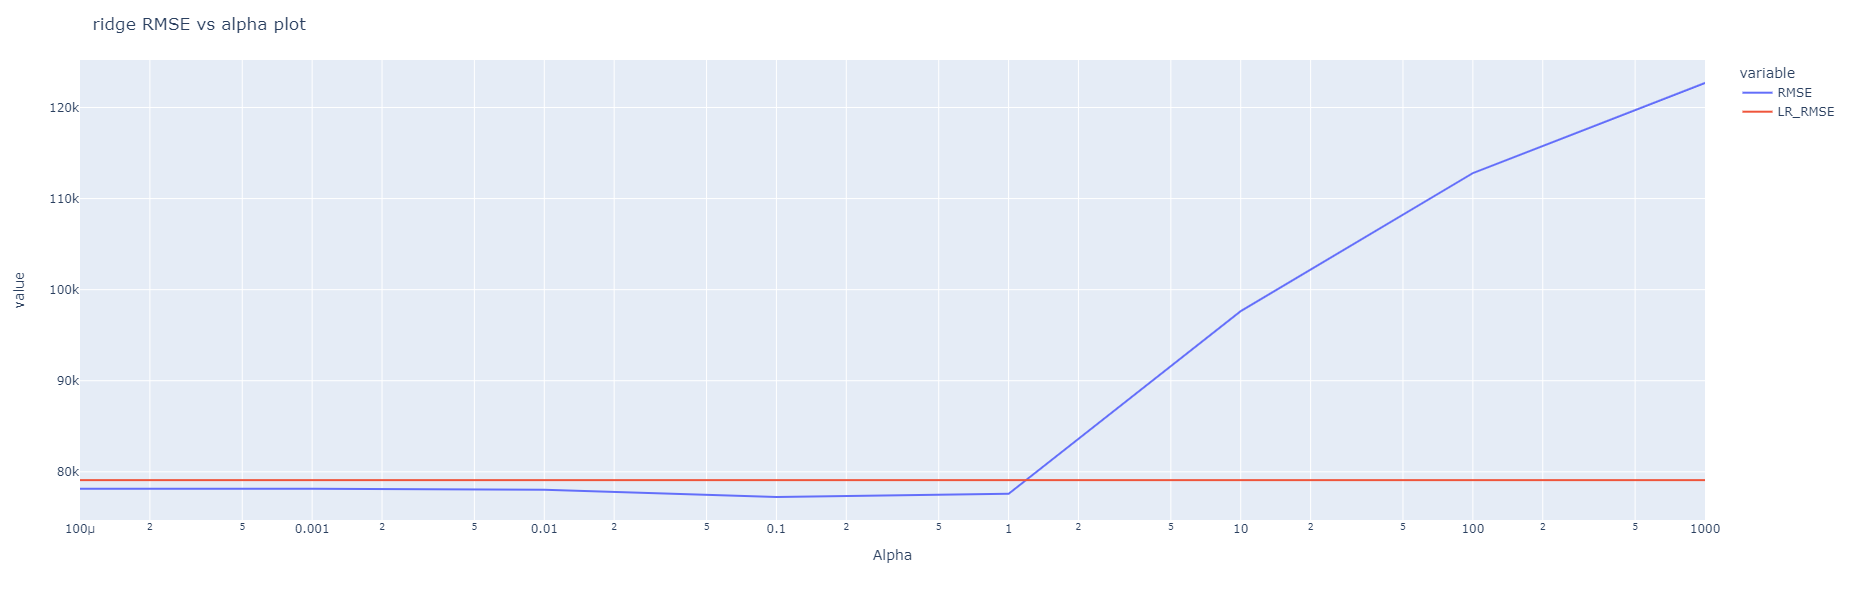

In [42]:
df_results = pd.DataFrame({'Alpha':alphas,
                           'RMSE': errors,
                           'r2': r2_scores,
                           'LR_RMSE': [lr_rmse]*len(alphas),
                           'LR_r2': [lr_test_r2]*len(alphas)
                          })
metric = 'RMSE'

fig = df_results.plot(x='Alpha', y=[metric, f'LR_{metric}'], log_x=True)
fig.update_layout(title=f"{model_reg} {metric} vs alpha plot", height=600, width=1000)
fig.show()

## LASSO regression

In [43]:
from sklearn.linear_model import Lasso

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
model_reg = 'lasso'
errors = []
r2_scores = []

for alpha in tqdm(alphas):
    if model_reg.lower() == 'lasso':
        model = Lasso(alpha=alpha, tol=0.1)
    elif model_reg.lower() == 'ridge':
        model = Ridge(alpha=alpha)
    rmse, test_r2, _ = cross_fold(df_all, model)
    
    errors.append(rmse)
    r2_scores.append(test_r2)
    
lr_rmse, lr_test_r2, lr_train_t2 = cross_fold(df_all, linear_model.LinearRegression(), False)

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


By plotting the metrics vs each alpha value we see that: 
* LASSO regression slightly improves the performance of the model for values of alpha <= 100. 
* alpha = 100 gives the best peformance.
* LASSO with alpha = 100 outperforms ridge regression.

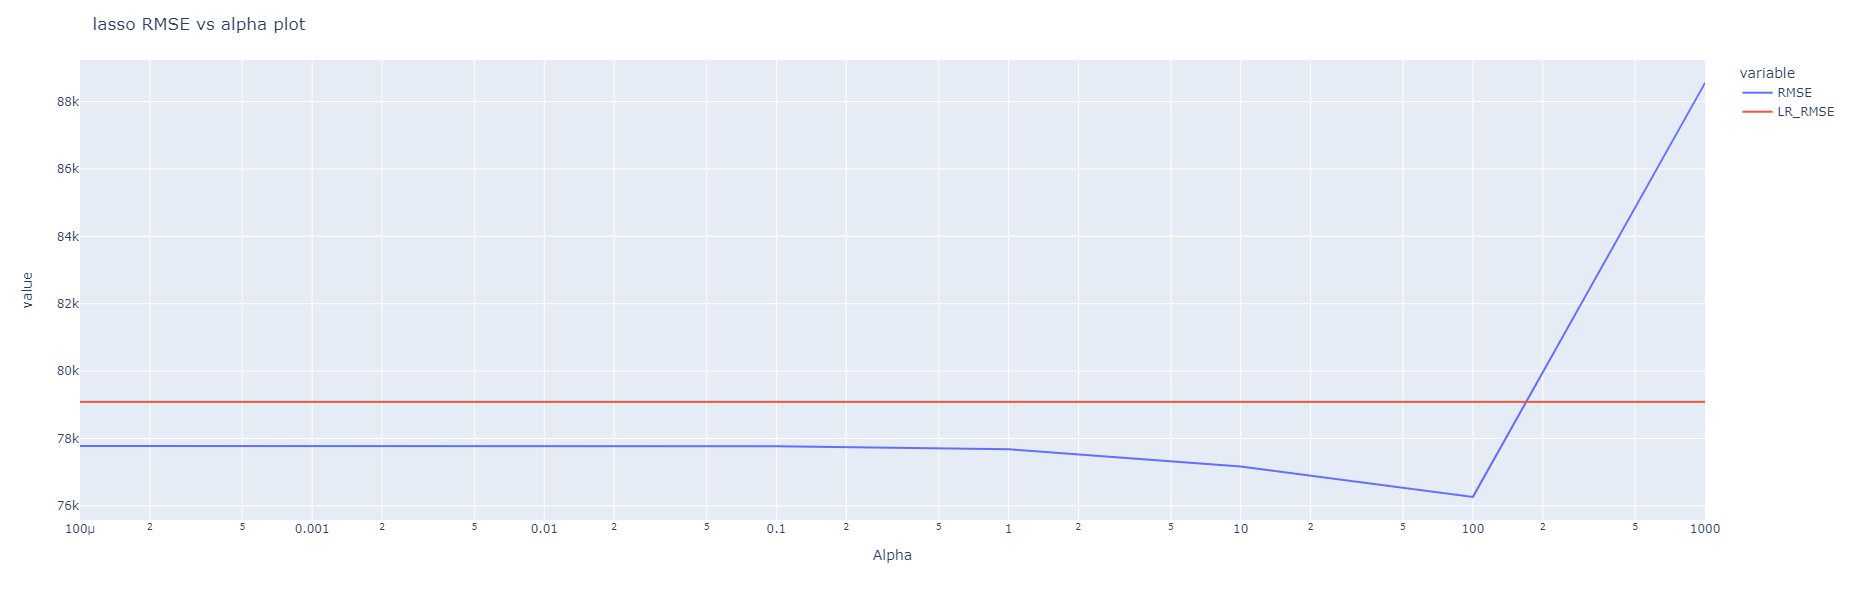

In [44]:
df_results = pd.DataFrame({'Alpha':alphas,
                           'RMSE': errors,
                           'r2': r2_scores,
                           'LR_RMSE': [lr_rmse]*len(alphas),
                           'LR_r2': [lr_test_r2]*len(alphas)
                          })
metric = 'RMSE'

fig = df_results.plot(x='Alpha', y=[metric, f'LR_{metric}'], log_x=True)
fig.update_layout(title=f"{model_reg} {metric} vs alpha plot", height=600, width=1000)
fig.show()

# Plot LASSO coefficients
Since LASSO regression shrinks the coefficients of 'uninformative' features to zero, it can also be used a feature selection technique. <br>
By plotting a bar plot of the LASSO coefficients of each feature we can get a sense of what featues contribute the most towards the model's performance. 
I set the parameter alpha = 100 as this was the best performing setting for LASSO regression. 

In [45]:
alpha = 100
model = Lasso(alpha=alpha)
X_train, X_test, y_train, y_test = train_test_split(train_test[feature_area], train_test[target], test_size=test_ratio, random_state=123)
numeric_columns = list(X_train.columns[X_train.dtypes != object])
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
X_train, X_test, ohc = encode_data(X_train, X_test)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse =  mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

print("LASSO root mean squared error: %.2f" % rmse)
print("Test coefficient of determination: %.2f" % r2)
print("Train coefficient of determination: %.2f" % r2_train)

LASSO root mean squared error: 81618.96
Test coefficient of determination: 0.51
Train coefficient of determination: 0.82


In [47]:
test_areas = ['E41d', 'E15b', 'A09a']
for area in test_areas:
    df_input = encode_area(ohc, df_all[df_all.area.str.contains(area)][feature_area] )
    df_input[numeric_columns] = scaler.transform(df_input[numeric_columns])
    print(f"Predicted avg. woz value for area {area} = {round(model.predict(df_input)[0])}")

Predicted avg. woz value for area E41d = 104769
Predicted avg. woz value for area E15b = 249190
Predicted avg. woz value for area A09a = 287993


### Feature importance
Plotting the coefficients of the LASSO regression we notice the following:
* area-codes are by far the most informative featues. 
* We can clearly see that the most expensive area (K 49) and the least expensive area (M34) have the largest absolute coefficients.
* Certain family compositions are not so informative: 'total', 'other', 'married with kids', 'married no kids' have relatively small coefficients.
* We can see a clear difference between negative and postive coefficients: more expensive areas have postive coefficients, less expensive areas and interestingly the 'single' and 'single-parent' composition have negative coefficients. 

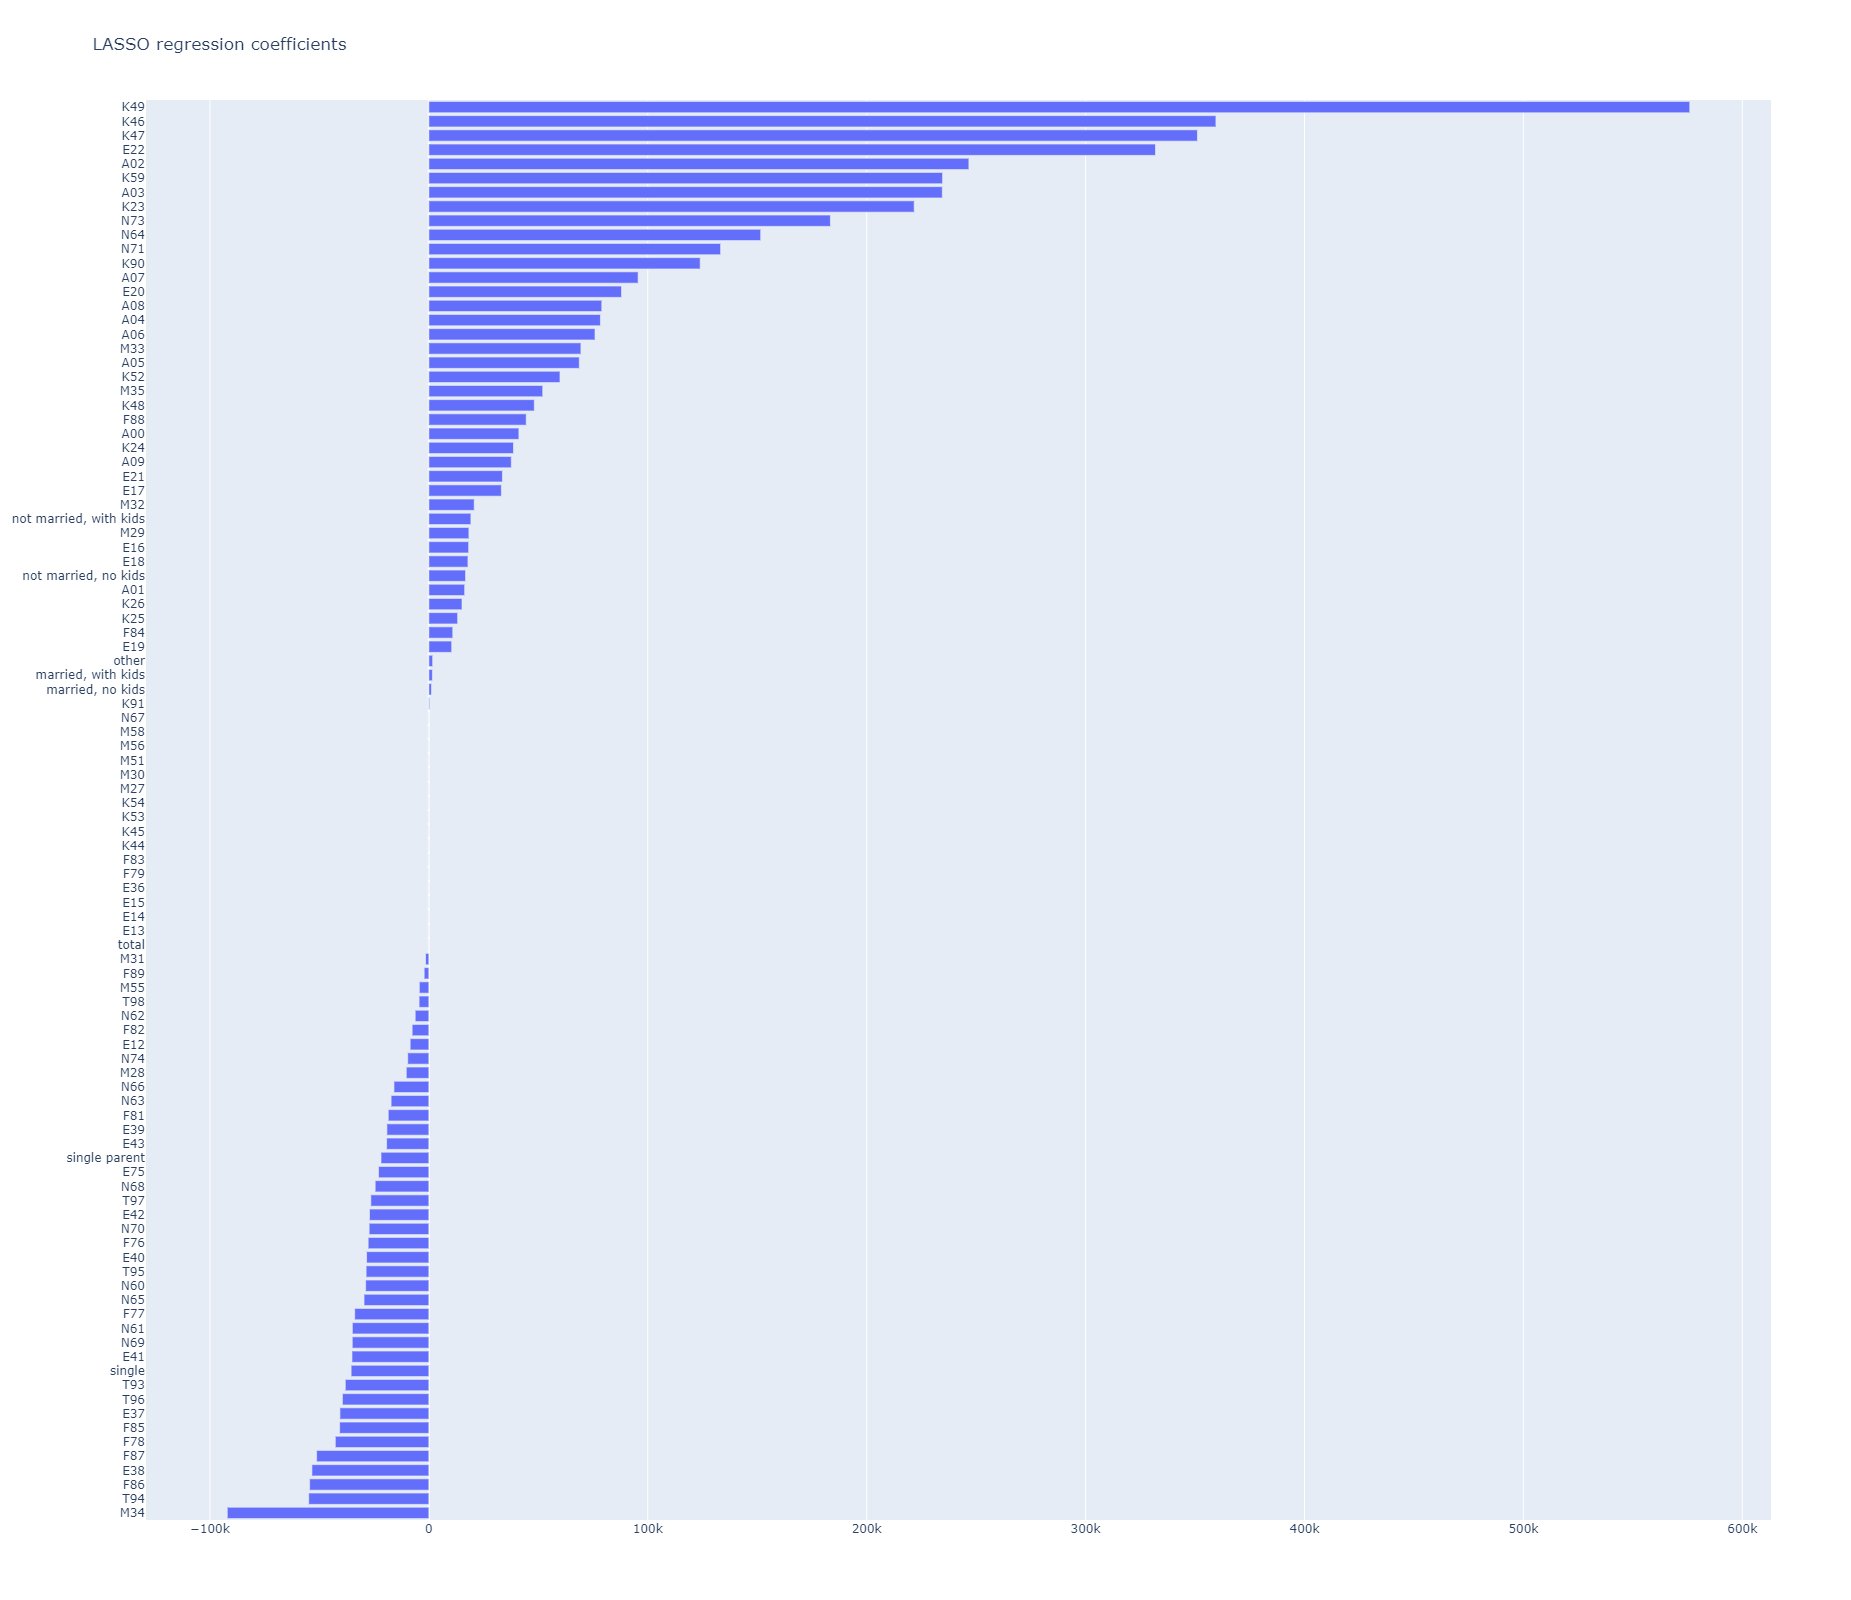

In [48]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(y=X_train.columns, x=model.coef_, orientation='h') )
fig.update_layout(height=1600, title='LASSO regression coefficients')
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

## Potential improvements
* Do a wider grid-search to better determine the effect of alpha in LASSO & Ridge and find the optimal alpha parameter.
* Removing features that have a low LASSO regresison coefficient --> see if it improves performance. 
* Test elastic-net.
* Try making a less fine grained area feature (e.g. using just the letter instead of the letter+digits).
* Adding extra data (e.g. adding coordinates) and create extra features (e.g distance from city centre).

# Conclusion
We can conclude the following:
- The average price of an area depends on the family composition of the area. Most obviously: the more people that live there, the lower the average price. 
- The average price of an area depends on the area itself.
- Adding an extra feature based on area improves the model performance. 
- Regulariaztion such as LASSO/Ridge improve the model performance. 
- LASSO regression shows which features are the most important to the model.
